# Conexiones de cohesion lexica promedio del corpus de introducciones de la revista CELL

# Lexical graphs

## stopwords y vectores GLOVE
### http://www.lextek.com/manuals/onix/stopwords2.html
### https://nlp.stanford.edu/projects/glove/

In [14]:
import numpy as np
import random
from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import itertools
from scipy import spatial
import networkx as nx
import ast
import re
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
import random

data=open('stopwords.txt','r')
data_read = data.read()
stop_words=data_read.replace('\n',' ').split()

vectors = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    vectors[word] = coefs
f.close()

## vectores aleatorios para las palabras fuera de vocabulario (se mantienen iguales para el mismo texto)

In [15]:
def glove_text(text):
    text=list(set([w.lower() for w in tokenizer.tokenize(text)]))
    text=[w for w in text if w not in stop_words]
    glove_vectors={}
    for w in text:
        if w not in vectors.keys():
            vector=[1]*300
            vector=[x*random.uniform(-1.5,1.5) for x in vector]
            vector=np.array(vector)
            glove_vectors[w]=vector
        else:
            glove_vectors[w]=vectors[w]
    return glove_vectors

## distancias entre palabras y oraciones

In [16]:
def simglove(vector_i,vector_j):
    return 1-spatial.distance.cosine(vector_i.reshape(1,-1),vector_j.reshape(1,-1))

def sent_distance(text,index_sent_i,index_sent_j,threshold): 
    glove_vectors=glove_text(text)
    sentences=sent_tokenize(text)
    sent_i=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent_i])]))
    sent_i=[w for w in sent_i if w not in stop_words]
    sent_j=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent_j]) if w not in stop_words]))
    sent_j=[w for w in sent_j if w not in stop_words]

    p=list(itertools.product(sent_i,sent_j))
    d=[]
    for item in p:
        d+=[simglove(glove_vectors[item[0]],glove_vectors[item[1]])]
    if len(d)==0:
        return -1
    else:
        if max(d)>=threshold:
            return max(d)
        else:
            return -1

## lexical graph
### http://aclweb.org/anthology/N16-1167
### http://aclweb.org/anthology/W17-4803

In [17]:
def lexical_graph(text):
    sentences=sent_tokenize(text)
    G=nx.DiGraph()
    for i in range(len(sentences)):
        G.add_node(i)
    pairs=list(itertools.combinations(range(len(sentences)),2)) ## solo aristas dirigidas en el sentido del texto!
    for pair in pairs:
        dist=sent_distance(text,pair[0],pair[1],0.85)
        if dist!=-1:
            G.add_edge(pair[0],pair[1],weight=round(dist,4)) 
    return G

# Cohesion (con threshold 0.85) para introducciones revista CELL

In [60]:
data = open('corpus_cell.json','r')
data_cell=data.read()
data_cell = ast.literal_eval(data_cell)
introductions=[' '.join(item['introduction']) for item in data_cell]
introductions=[re.sub("[\(\[].*?[\)\]]", "", item) for item in introductions]
introductions=[x for x in introductions if len(x)>0]
introductions=[' '.join([s for s in sent_tokenize(text) if len(s)>1]) for text in introductions]

### cohersion = average outdegree

In [19]:
def coherence(G): 
    D=dict(G.out_degree(weight='weight'))
    D_out=list(D.values())
    return np.mean(D_out)

print(coherence(lexical_graph(introductions[0])))
    

4.67688947368421


### cohesion promedio de introducciones de CELL

In [20]:
n=multiprocessing.cpu_count()

graphs=Parallel(n_jobs=n)(delayed(lexical_graph)(text) for text in introductions)

In [21]:
cohesion_promedio_CELL=Parallel(n_jobs=n)(delayed(coherence)(graph) for graph in graphs)

In [22]:
cohesion_dict={x:[y] for x,y in zip(range(len(cohesion_promedio_CELL)),cohesion_promedio_CELL)}

C=pd.DataFrame(cohesion_dict)
C.to_csv('cohesion.csv')

### cohesion

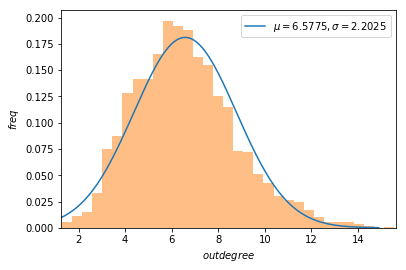

In [23]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(cohesion_promedio_CELL) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0, 15, 0.1) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=6.5775,\sigma=2.2025$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$outdegree$')
plt.ylabel('$freq$')
plt.show()

In [24]:
m,s

(6.577576373362595, 2.202598906012723)

# Cohesion (sin threshold) para introducciones revista CELL

In [25]:
def lexical_graph_without(text):
    sentences=sent_tokenize(text)
    G=nx.DiGraph()
    for i in range(len(sentences)):
        G.add_node(i)
    pairs=list(itertools.combinations(range(len(sentences)),2)) ## solo aristas dirigidas en el sentido del texto!
    for pair in pairs:
        dist=sent_distance(text,pair[0],pair[1],0.)
        if dist!=-1:
            G.add_edge(pair[0],pair[1],weight=round(dist,4)) 
    return G

### cohesion promedio (sin threshold) de introducciones de CELL

In [26]:
graphs_without=[lexical_graph_without(text) for text in introductions]

In [27]:
cohesion_promedio_CELL_without=Parallel(n_jobs=n)(delayed(coherence)(graph) for graph in graphs_without)

In [28]:
cohesion_dict_without={x:[y] for x,y in zip(range(len(cohesion_promedio_CELL_without)),cohesion_promedio_CELL_without)}

C=pd.DataFrame(cohesion_dict_without)
C.to_csv('cohesion_without.csv')

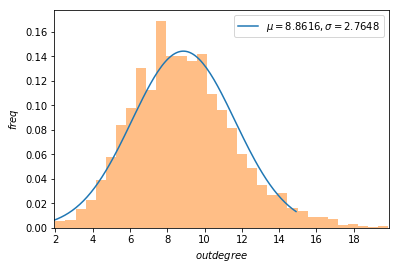

In [33]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(cohesion_promedio_CELL_without) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0, 15, 0.1) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=8.8616,\sigma=2.7648$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$outdegree$')
plt.ylabel('$freq$')
plt.show()

In [34]:
m,s

(8.861679976131105, 2.7648827732249037)

# Distancia entre oraciones sucesivas introducciones CELL

### funcion para distancia entre oraciones

In [35]:
def sent_distance_average(text,index_sent_i,index_sent_j): 
    glove_vectors=glove_text(text)
    sentences=sent_tokenize(text)
    sent_i=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent_i])]))
    sent_i=[w for w in sent_i if w not in stop_words]
    sent_j=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent_j]) if w not in stop_words]))
    sent_j=[w for w in sent_j if w not in stop_words]
    
    ### vectores de las oraciones!
    sent_i=[glove_vectors[word] for word in sent_i]
    sent_j=[glove_vectors[word] for word in sent_j]
    
    
    if len(sent_i)>0 and len(sent_j)>0:
        ### vectores suma
        sent_i=np.sum(sent_i, axis=0)
        sent_j=np.sum(sent_j, axis=0)
        return simglove(sent_i,sent_j)
    else:
        return -2

def average_succesive(text): 
    average=0
    n=len(sent_tokenize(text))
    pairs=list(zip(range(n),range(n)[1:]))
    p=0
    for pair in pairs:
        r=sent_distance_average(text,pair[0],pair[1])
        if r!=-2:
            average+=r
            p+=1
        
    return average/float(p)

In [36]:
text=introductions[0]
sent_distance_average(text,0,1)

0.6604255603973552

In [37]:
average_succesive(text)

0.6479247540734778

### average distance 

In [38]:
n=multiprocessing.cpu_count()

average_succesive_CELL=Parallel(n_jobs=n)(delayed(average_succesive)(text) for text in introductions)


In [39]:
succesive_dict={x:[y] for x,y in zip(range(len(average_succesive_CELL)),average_succesive_CELL)}

C=pd.DataFrame(succesive_dict)
C.to_csv('succesive.csv')

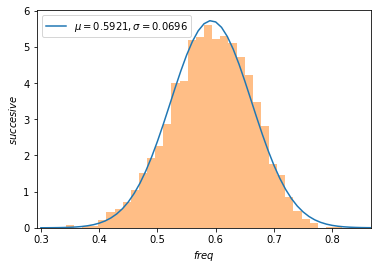

In [42]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(average_succesive_CELL) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0.3, 0.9, 0.01) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=0.5921,\sigma=0.0696$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$freq$')
plt.ylabel('$succesive$')
plt.show()

In [43]:
m,s

(0.5921092086909895, 0.06966503406350417)

### average con ventana de analisis (caso mas simple: anterior y posterior)

In [44]:
def sent_window_average(text,index_sent): 
    glove_vectors=glove_text(text)
    sentences=sent_tokenize(text)
    n=len(sentences)
    if index_sent==0:
        sent_i=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent])]))
        sent_i=[w for w in sent_i if w not in stop_words]
        sent_j=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent+1]) if w not in stop_words]))
        sent_j=[w for w in sent_j if w not in stop_words]
    
        ### vectores de las oraciones!
        sent_i=[glove_vectors[word] for word in sent_i]
        sent_j=[glove_vectors[word] for word in sent_j]
    
        if len(sent_i)>0 and len(sent_j)>0:
            ### vectores suma
            sent_i=np.sum(sent_i, axis=0)
            sent_j=np.sum(sent_j, axis=0)
            return simglove(sent_i,sent_j)
        else:
            return -2
    elif index_sent==n-1:
        sent_i=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent])]))
        sent_i=[w for w in sent_i if w not in stop_words]
        sent_j=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent-1]) if w not in stop_words]))
        sent_j=[w for w in sent_j if w not in stop_words]
    
        ### vectores de las oraciones!
        sent_i=[glove_vectors[word] for word in sent_i]
        sent_j=[glove_vectors[word] for word in sent_j]
    
        if len(sent_i)>0 and len(sent_j)>0:
            ### vectores suma
            sent_i=np.sum(sent_i, axis=0)
            sent_j=np.sum(sent_j, axis=0)
            return simglove(sent_i,sent_j)
        else:
            return -2
    else:
        sent=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent])]))
        sent=[w for w in sent if w not in stop_words]
        
        sent_L=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent-1]) if w not in stop_words]))
        sent_L=[w for w in sent_L if w not in stop_words]
        
        sent_R=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent+1]) if w not in stop_words]))
        sent_R=[w for w in sent_R if w not in stop_words]
    
        ### vectores de las oraciones!
        sent=[glove_vectors[word] for word in sent]
        sent_L=[glove_vectors[word] for word in sent_L]
        sent_R=[glove_vectors[word] for word in sent_R]

    
        if len(sent)>0 and len(sent_L)>0 and len(sent_R)>0:
            ### vectores suma
            sent=np.sum(sent, axis=0)
            sent_L=np.sum(sent_L, axis=0)
            sent_R=np.sum(sent_R, axis=0)
            return (simglove(sent,sent_L)+simglove(sent,sent_R))/float(2)
        else:
            return -2

def average_succesive_window(text): 
    average=0
    n=len(sent_tokenize(text))
    p=0
    for i in range(n):
        r=sent_window_average(text,i)
        if r!=-2:
            average+=r
            p+=1
        
    return average/float(p)

In [45]:
average_window_CELL=Parallel(n_jobs=n)(delayed(average_succesive_window)(text) for text in introductions)

In [46]:
window_dict={x:[y] for x,y in zip(range(len(average_window_CELL)),average_window_CELL)}

C=pd.DataFrame(window_dict)
C.to_csv('window.csv')

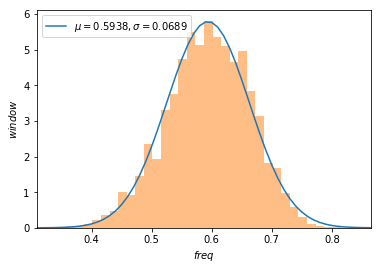

In [49]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(average_window_CELL) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0.3, 0.9, 0.01) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=0.5938,\sigma=0.0689$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$freq$')
plt.ylabel('$window$')
plt.show()

In [50]:
m,s

(0.5938135485099072, 0.06891099606572364)

# Experimento con textos desordenados (introducciones de la revista CELL) 
### Comparamos la distribucion que hemos descrito en los tres casos anteriores con versiones desordenadas de los textos

### corpus de textos desordenados (x cada uno definimos K = 10 versiones)

In [61]:
import random
introductions=random.sample(introductions,1000)

random_corpus={}
K=10
for i in range(len(introductions)):
    random_versions=[]
    for j in range(K):
        text_random=sent_tokenize(introductions[i])
        text_random=random.sample(text_random,len(text_random))
        text_random=' '.join(text_random)
        random_versions+=[text_random]
    random_corpus[i]=random_versions
    

### partimos con la coherencia como grado de salida promedio


In [62]:
graphs_random={}
for i in range(len(introductions)):
    graphs_random[i]=[lexical_graph(text) for text in random_corpus[i]]
    

In [63]:
cohesion_random={}
for i in range(len(introductions)):
    cohesion_list=[]
    for j in range(K):
        cohesion_list+=[coherence(graphs_random[i][j])]
    cohesion_random[i]=cohesion_list

In [64]:
values_random=[item for sublist in cohesion_random.values() for item in sublist]

C=pd.DataFrame(values_random)
C.to_csv('cohesive_random.csv')

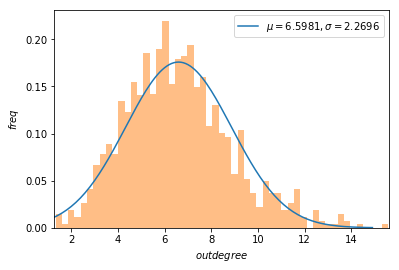

In [67]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(values_random) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0, 15, 0.1) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=6.5981,\sigma=2.2696$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$outdegree$')
plt.ylabel('$freq$')
plt.show()

In [66]:
m,s

(6.59812028132696, 2.2696612463315837)

### seguimos con la coherencia como grado de salida promedio sin threshold


In [68]:
graphs_random={}
for i in range(len(introductions)):
    graphs_random[i]=[lexical_graph_without(text) for text in random_corpus[i]]